# Import Dataset, drop 0 columns

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def clean_csv_files(folder_path):
  cleaned_dataframes = {}

  # List of columns to drop
  columns_to_drop = [
      "status", "start_date", "end_date", "window_start_date", "window_end_date",
      "emails", "devs", "emails_thread_starter", "emails_thread_starter_word_count",
      "emails_thread_starter_characters", "emails_threads", "emails_threads_word_count",
      "emails_threads_characters", "emails_no_replies", "emails_no_replies_word_count",
      "emails_no_replies_characters", "emails_jira", "most_complex_unit_loc",
      "most_complex_unit_mcabe_index", "total_number_of_files", "number_of_files_main",
      "lines_of_code_main", "number_of_files_test", "lines_of_code_test",
      "test_vs_main_lines_of_code_percentage", "number_of_files_generated",
      "lines_of_code_generated", "number_of_files_build_and_deployment",
      "lines_of_code_build_and_deployment", "negligible_risk_file_size_count",
      "low_risk_file_size_count", "medium_risk_file_size_count", "high_risk_file_size_count",
      "very_high_risk_file_size_count", "negligible_risk_file_size_loc", "low_risk_file_size_loc",
      "medium_risk_file_size_loc", "high_risk_file_size_loc", "very_high_risk_file_size_loc",
      "number_of_units", "lines_of_code_in_units", "lines_of_code_outside_units",
      "unit_size_negligible_risk_loc", "unit_size_negligible_risk_count", "unit_size_low_risk_loc",
      "unit_size_low_risk_count", "unit_size_medium_risk_loc", "unit_size_medium_risk_count",
      "unit_size_high_risk_loc", "unit_size_high_risk_count", "unit_size_very_high_risk_loc",
      "unit_size_very_high_risk_count", "conditional_complexity_negligible_risk_loc",
      "conditional_complexity_negligible_risk_count", "conditional_complexity_low_risk_loc",
      "conditional_complexity_low_risk_count", "conditional_complexity_medium_risk_loc",
      "conditional_complexity_medium_risk_count", "conditional_complexity_high_risk_loc",
      "conditional_complexity_high_risk_count", "conditional_complexity_very_high_risk_loc",
      "conditional_complexity_very_high_risk_count", "conditional_complexity_high_plus_risk_count",
      "conditional_complexity_high_plus_risk_loc", "number_of_contributors",
      "duplication_number_of_duplicates", "duplication_number_of_files_with_duplicates",
      "duplication_number_of_duplicated_lines", "duplication_percentage", "unit_duplicates_count", "releases"
  ]

  for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
      file_path = os.path.join(folder_path, filename)

      # Load CSV file
      df = pd.read_csv(file_path)

      # Drop specified columns
      df = df.drop(
          columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

      key = os.path.splitext(filename)[0]
      cleaned_dataframes[key] = df

  return cleaned_dataframes

folder_path = "scraper-output"
cleaned_data = clean_csv_files(folder_path)


# Clean data

In [2]:
import pandas as pd
import numpy as np

for key, df in cleaned_data.items():
    # Replace NaN values in numerical columns with 0
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(0)

    # Replace NaN and blank/empty values in 'programming_lang' column with the mode
    if 'programming_lang' in df.columns:
        # Calculate mode value
        mode_value = df['programming_lang'].mode()[0] if not df['programming_lang'].mode().empty else 'Unknown'
        
        # Replace NaN values with the mode
        df['programming_lang'] = df['programming_lang'].fillna(mode_value)
        
        # Replace blank or whitespace-only values with the mode
        df['programming_lang'] = df['programming_lang'].replace(r'^\s*$', mode_value, regex=True)

# Time series analysis on most important features

In [3]:
status_data = pd.read_csv("project-status.csv")
status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   project  154 non-null    object
 1   status   154 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


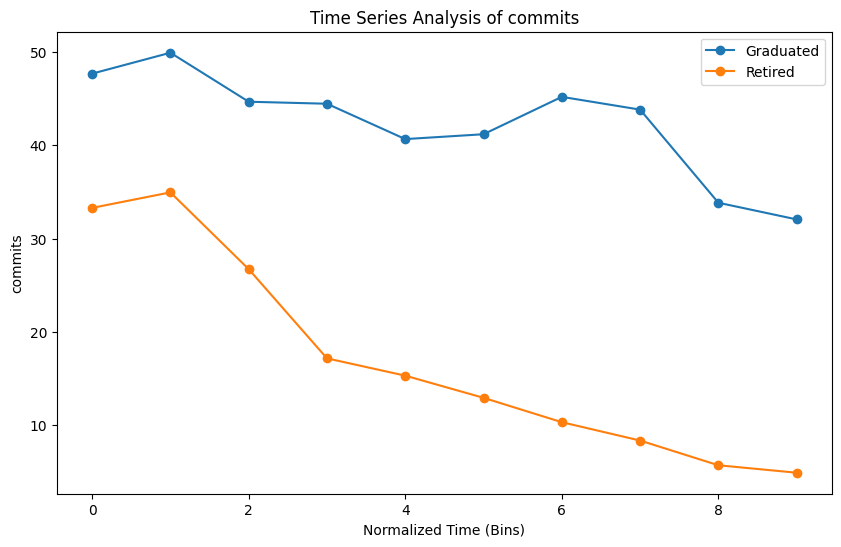

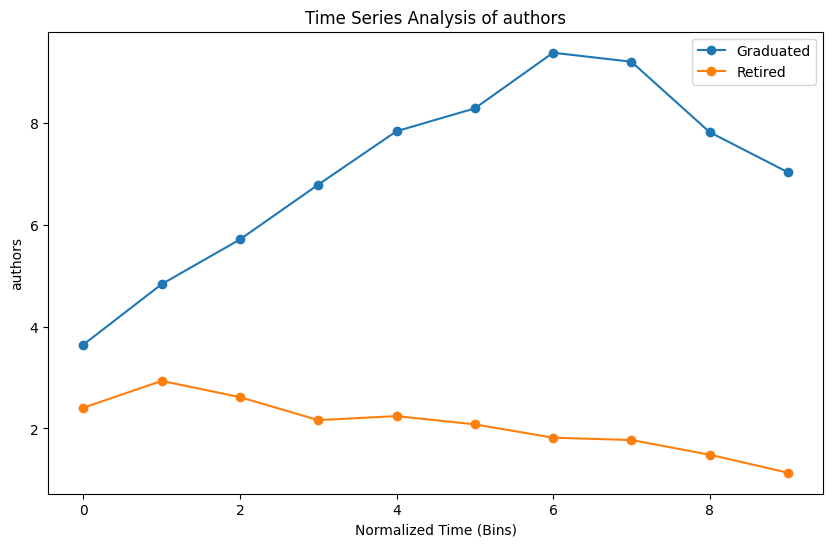

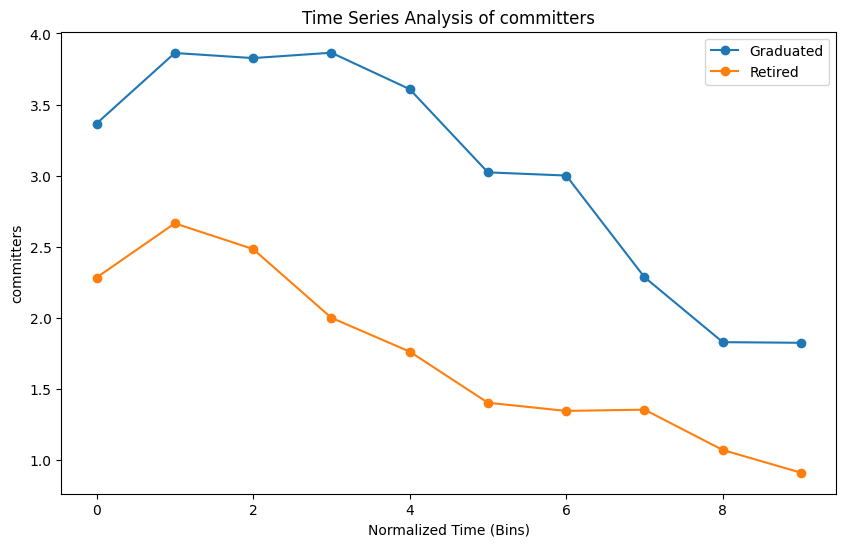

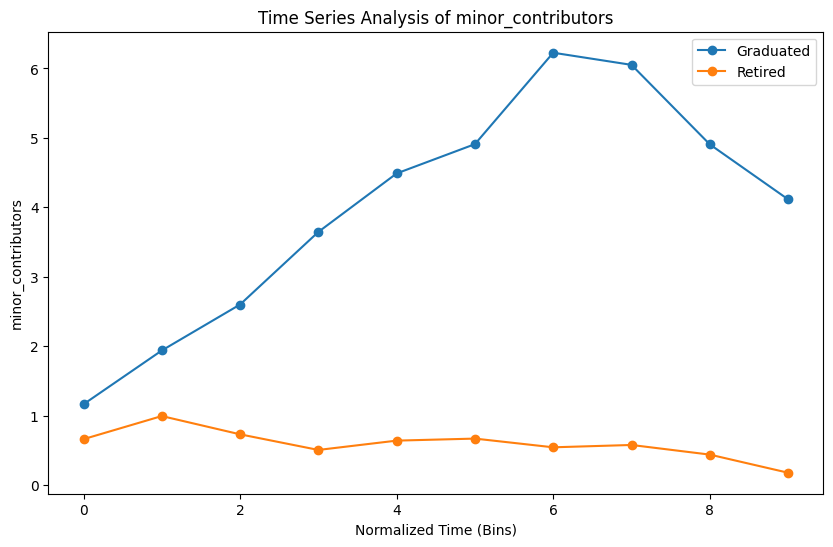

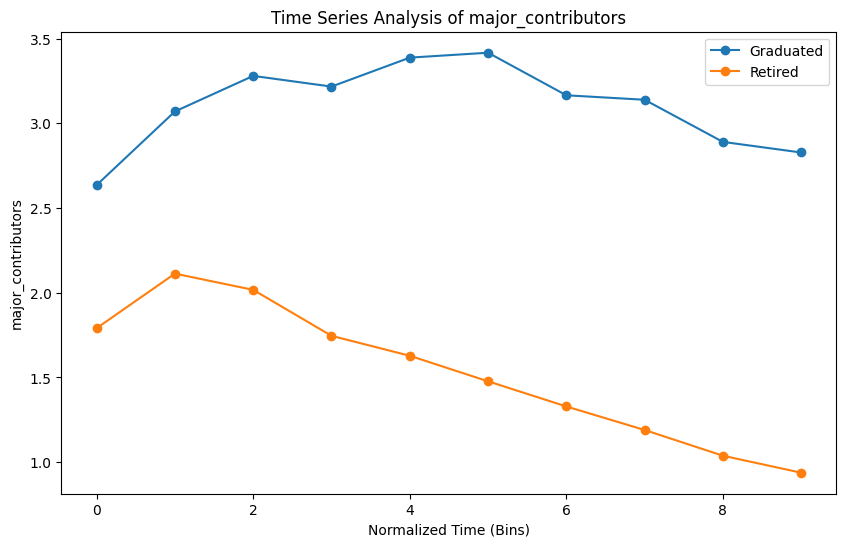

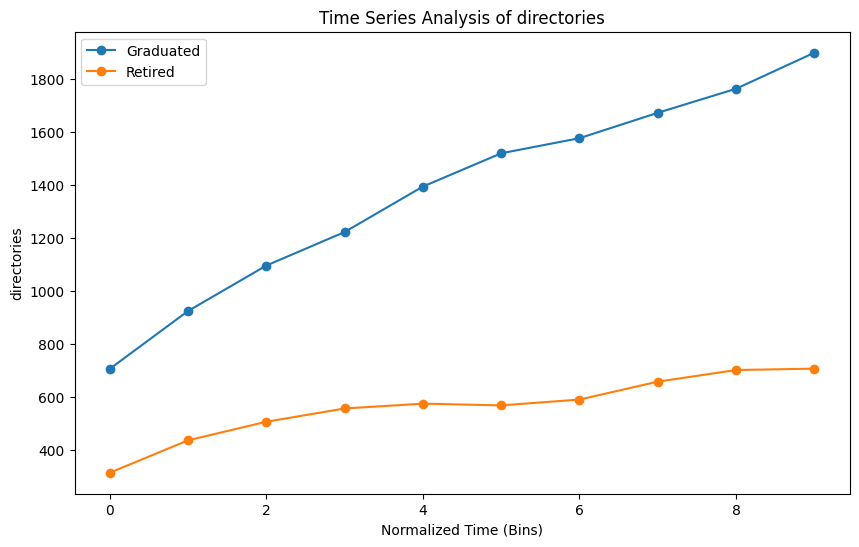

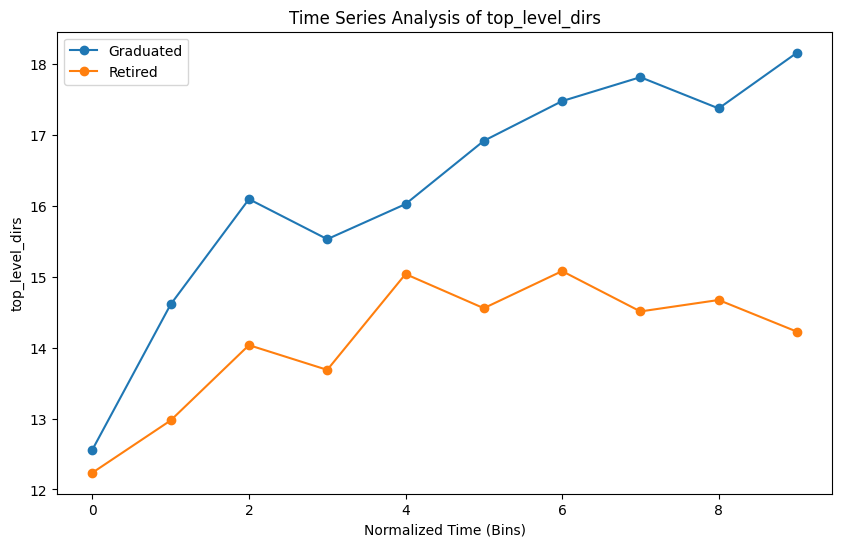

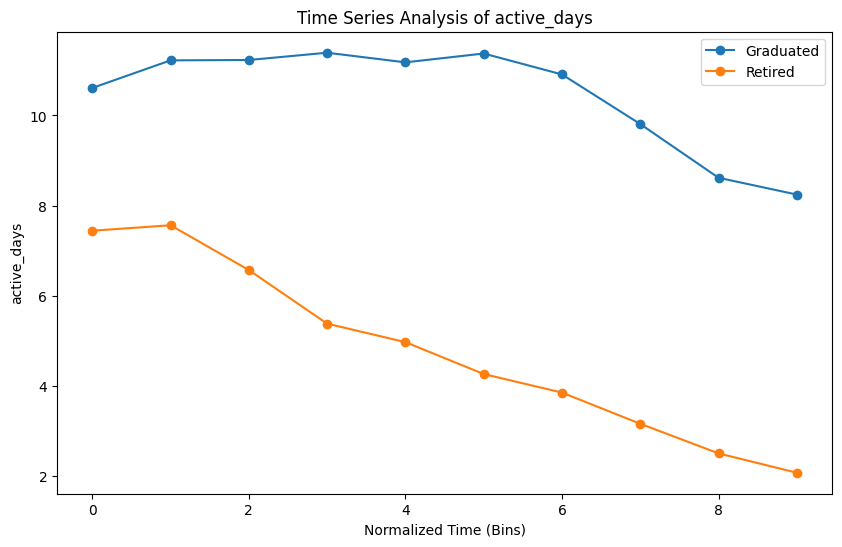

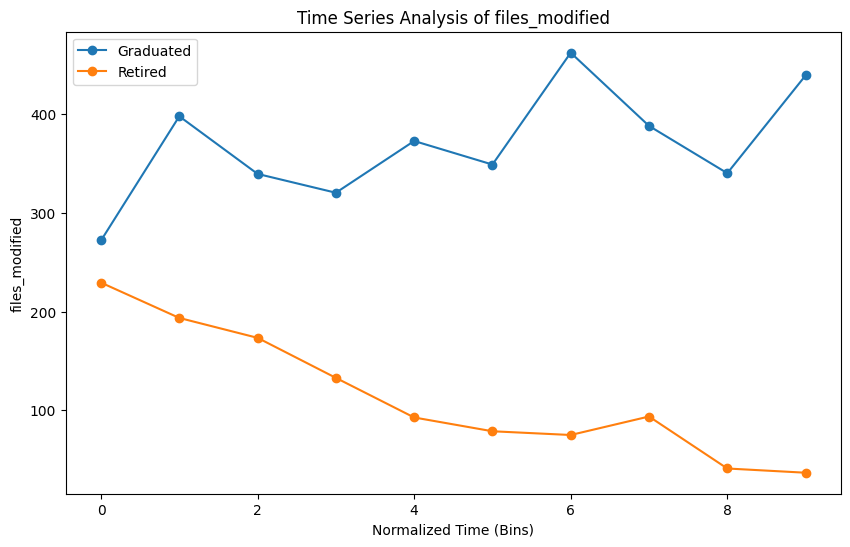

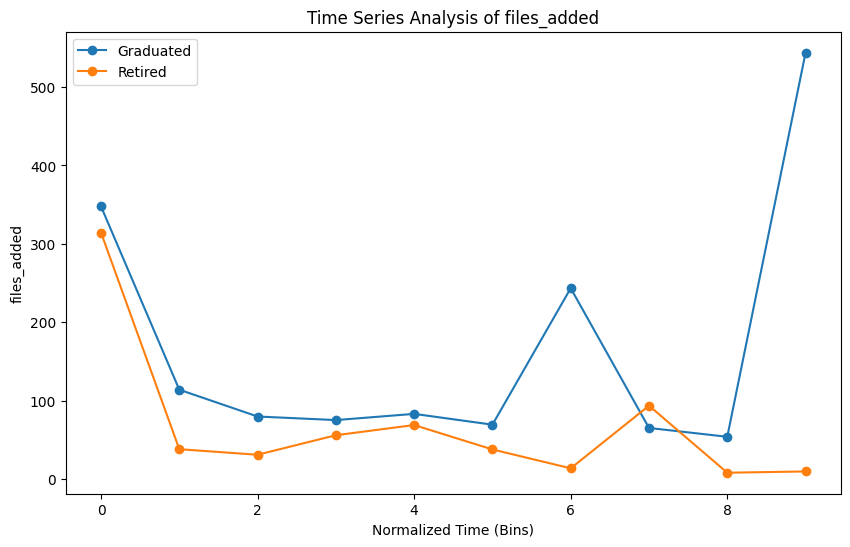

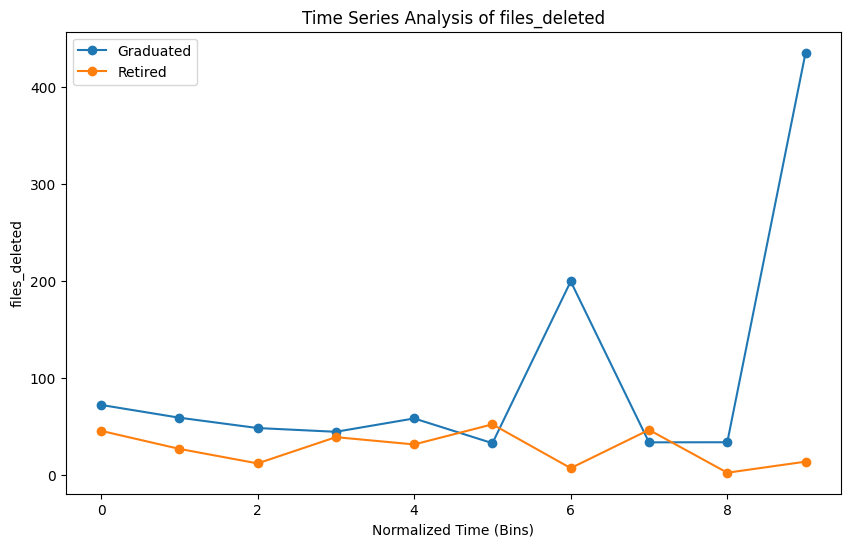

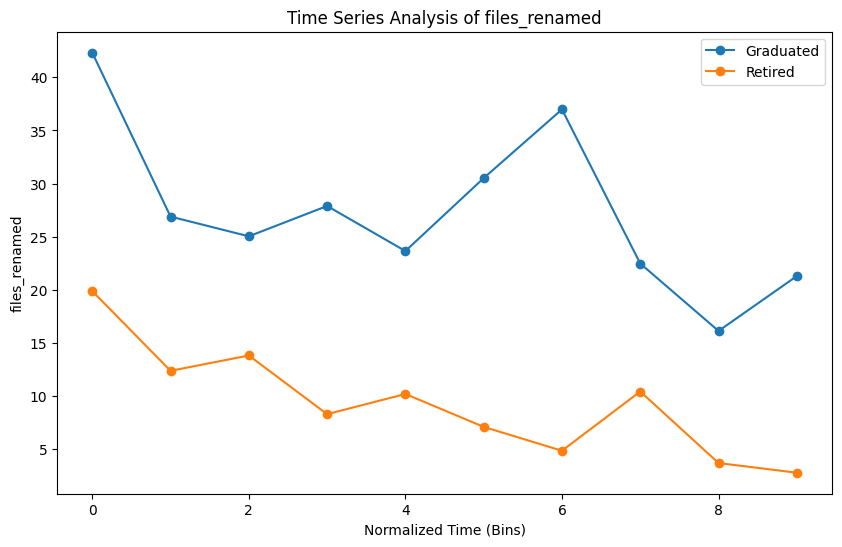

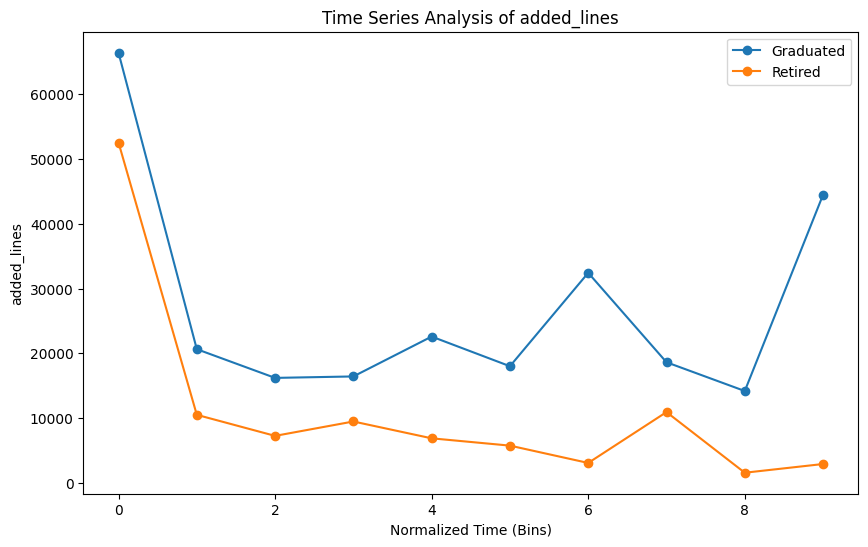

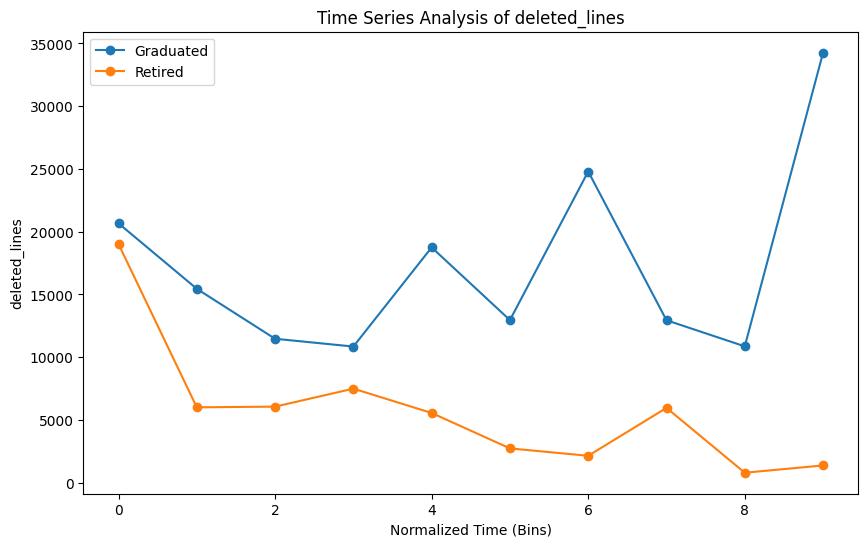

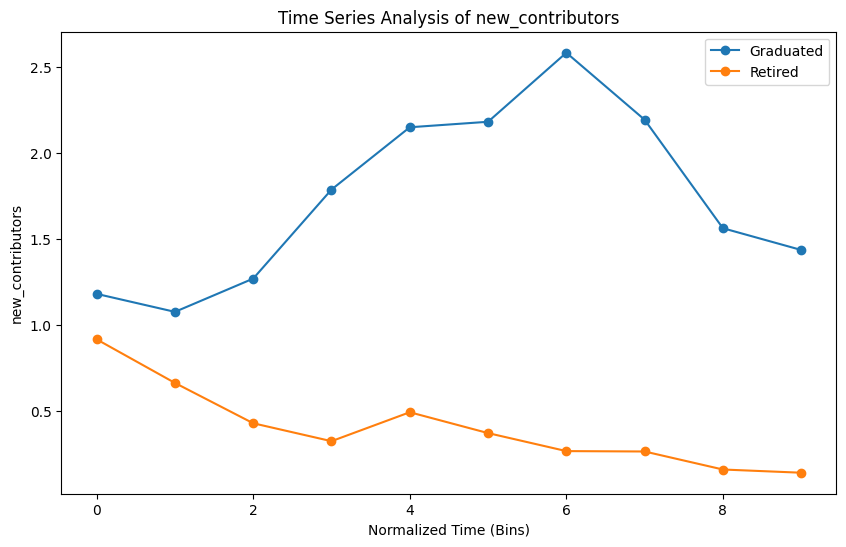

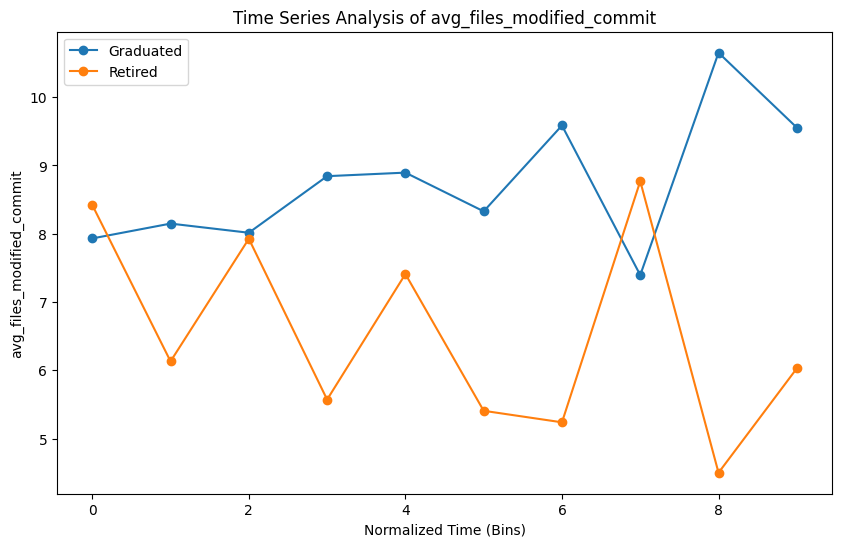

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter out projects with fewer than 10 data points
cleaned_data = {project: df for project,
                df in cleaned_data.items() if len(df) >= 10}

# Filter status_data to only include projects present in cleaned_data
status_data_filtered = status_data[status_data['project'].isin(
    cleaned_data.keys())]


# Merge project status into each dataframe
def merge_status(cleaned_data, status_data):
  status_dict = status_data.set_index('project')['status'].to_dict()
  for project, df in cleaned_data.items():
    df['status'] = status_dict.get(project, 'Unknown')
  return cleaned_data

# Function to extract 1/10th segments and compute averages
def extract_average_feature(df, feature, num_bins=10):
  df = df.sort_values(by='measurement_month')  # Ensure time is sorted
  bin_size = max(1, len(df) // num_bins)  # Determine bin size
  averages = [df[feature].iloc[i *
                               bin_size: (i + 1) * bin_size].mean() for i in range(num_bins)]
  return averages

# Function to plot feature trends
def plot_feature(cleaned_data, status_data, feature, num_bins=10):
  cleaned_data = merge_status(cleaned_data, status_data)

  # Collect averaged data for each status
  grouped_data = {status: [[] for _ in range(
      num_bins)] for status in status_data['status'].unique()}
  for project, df in cleaned_data.items():
    if feature in df.columns:
      status = df['status'].iloc[0]
      averages = extract_average_feature(df, feature, num_bins)
      for i, avg in enumerate(averages):
        grouped_data[status][i].append(avg)

  # Compute overall average per bin for each status group
  plt.figure(figsize=(10, 6))
  for status, bins in grouped_data.items():
    avg_series = [
        np.mean(bin_values) if bin_values else 0 for bin_values in bins]
    plt.plot(range(num_bins), avg_series, marker='o', label=status)

  plt.xlabel('Normalized Time (Bins)')
  plt.ylabel(feature)
  plt.title(f'Time Series Analysis of {feature}')
  plt.legend()
  plt.show()

# Function to plot all features
def plot_all_features(cleaned_data, status_data, features, num_bins=10):
  for feature in features:
    plot_feature(cleaned_data, status_data, feature, num_bins)


plot_all_features(cleaned_data, status_data, [
    'commits', 'authors', 'committers', 'minor_contributors', 'major_contributors',
    'directories', 'top_level_dirs', 'active_days', 'files_modified', 'files_added',
    'files_deleted', 'files_renamed', 'added_lines', 'deleted_lines', 'new_contributors',
    'avg_files_modified_commit'
])